# Brosa Modes Applied to the Cf-252 $Y(A,TKE)$ sf Yield
# 3 Mode Approach - S1, S2, SL

In [2]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
from scipy.stats import chisquare
%matplotlib inline

In [3]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [4]:
def rearrange(YATKE):
    return np.transpose(np.asarray(YATKE).reshape(150, 200))

def YATKEplot(YATKE):
    fig, axes = pl.subplots(1, 1, figsize=(15, 10))
    c1 = plt.imshow(YATKE, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)
    
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)


In [5]:
#get yield data for Cf 252 *************************************************************************************
f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
lines=f.readlines()
YATKE_data=[]
for x in lines:
    x = x.split()
    if len(x) != 0:
        YATKE_data.append(x[2])
f.close()

#convert from strings to ints
YATKE_data = list(map(int, YATKE_data))

total = sum(YATKE_data)
#normalize yield data
YATKE_data = np.asarray([float(i)/total for i in YATKE_data])

In [6]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table width=60%>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</center>")
        return ''.join(html)
    
def print_params(params, prev = None):
    table = ListTable()
    labels = [r'$h_{l}$', r'$h_{s1}$', r'$h_{s2}$', r'$d_{min,l}$', r'$d_{min,s1}$', r'$d_{min,s2}$',
         r'$d_{max,l}$', r'$d_{max,s1}$', r'$d_{max,s2}$', r'$d_{dec,l}$', r'$d_{dec,s1}$', r'$d_{dec,s2}$', 
         r'$\bar{A}_{l}$', r'$\bar{A}_{s1}$', r'$\bar{A}_{s2}$', 
          r'$\sigma_{A,l}$', r'$\sigma_{A,s1}$', r'$\sigma_{A,s2}$']
    if (prev != None):
        table.append(['Parameter', 'Posterior Value', 'Prior Value', 'Delta', 'Delta (%)'])
        
        for i in range(len(labels)):
            table.append([labels[i], "{0:5.2f}".format(params[i]), "{0:5.2f}".format(prev[i]), 
                          "{0:5.2f}".format(params[i] - prev[i]),
                         "{0:5.2f}%".format((params[i] - prev[i])/prev[i]*100.)])
            
        
    else:
        table.append(['Parameter', 'Value'])
        for i in range(len(labels)):
            table.append([labels[i], "{0:5.2f}".format(params[i])])
    
    return table       
    

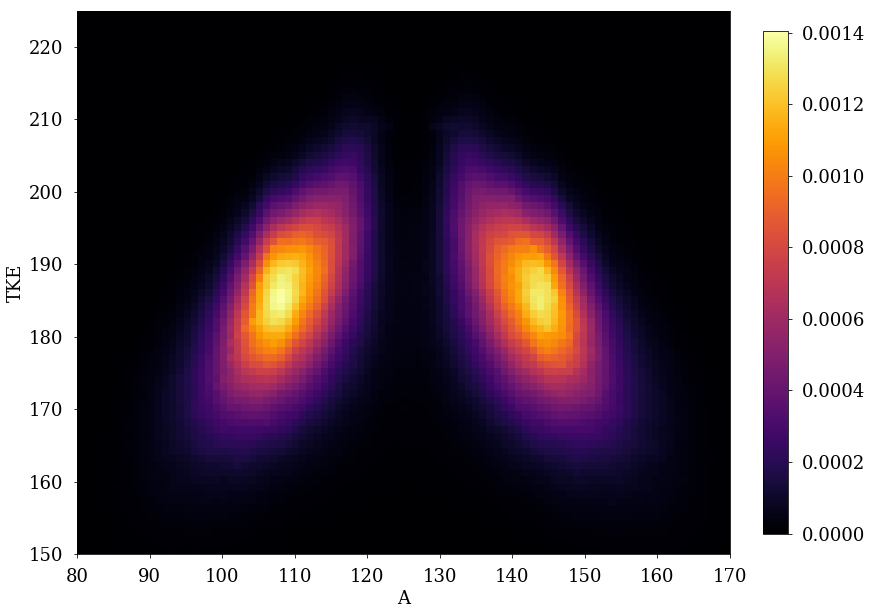

In [7]:
YATKEplot(rearrange(YATKE_data))

In [8]:
# model according to Brosa

def YATKE(tuple_in, h0,h1,h2, dmin0,dmin1,dmin2, dmax0,dmax1,dmax2,
         ddec0,ddec1,ddec2, Abar0,Abar1,Abar2, sigA0,sigA1,sigA2):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # pack the arrays - order of the modes is: SL, S1, S2
    # 30 total parameters, 5 modes x 6 parameters
    h           = np.array([h0,h1,h2])
    dmin        = np.array([dmin0, dmin1, dmin2])
    dmax        = np.array([dmax0, dmax1, dmax2]) 
    ddec        = np.array([ddec0, ddec1, ddec2])
    Abar        = np.array([Abar0, Abar1, Abar2])
    sigA        = np.array([sigA0, sigA1, sigA2])
    
    
    # define YATKE
    Y = [] # yield list that will be returned
    
    # sub "cn" refers to 'compound nucleus' - in this case the 252 pre-fission nucleus
    A_cn = 252.
    Z_cn = 98.
    
    e2 = 1.4399643929 # MeV fm
    #see http://www.vanderbilt.edu/AnS/physics/volker/p340a/section_1/1.3_notes_nucl_units.pdf
                        # e^2 = alpha * hbar * c
    # i index over A - turn into columns when rearranged
    for i in range(len(A)):
        # j index over TKE - rows of rearranged data
        for j in range(len(TKE)):
            Yij = 0.

            # k index over modes
            for k in range(len(h)):
                
                T = (Z_cn / A_cn) ** 2 * (A[i] * (A_cn - A[i]) * e2) / TKE[j] - dmin[k] # fm
                
                if (T <= 0.0):
                    Yij = 0.
                else:
                    YTKE = (200/TKE[j])** 2 * h[k] * np.exp(2*(dmax[k]-dmin[k])/ddec[k] - 
                                                       T/ddec[k] - (dmax[k] - dmin[k])**2/T/ddec[k])
                
                    #remember that the sL mode is NOT bimodal
                    if (k != 0):
                    
                        YA = 1/np.sqrt(8*np.pi*sigA[k]**2) * \
                        (np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2)) + \
                         np.exp(-(A[i]-A_cn+Abar[k])**2/(2*sigA[k]**2)))
                        
                    else:
                        YA = 1/np.sqrt(2*np.pi*sigA[k]**2) * \
                        np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2))

                    Yij += YTKE * YA
                
            Y.append(Yij)
            
    total = sum(Y)
    #normalize yield data
    Y = np.asarray([float(i)/total for i in Y])
    
    return np.asarray(Y)

In [9]:
# show how adjustments in d_min, d_max, and d_dec affect Y(TKE), Y(A)

hl, h1, h2 = 2.02e4, 1.47e5, 8.7e5
dminl, dmin1, dmin2 = 16.8, 10.9, 13.7
dmaxl, dmax1, dmax2 = 18.7, 17.1, 17.9
ddecl, ddec1, ddec2 = 0.521, 0.125, 0.270
Abarl, Abar1, Abar2 = 126.9, 134.9, 142.5
sigAl, sigA1, sigA2 = 11.62, 3.16,  4.99

# define A
A = np.linspace(51,200,150)

# define TKE
TKE = np.linspace(100,299,200)

YATKE_prior = YATKE((A,TKE), hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, 
                   ddecl, ddec1, ddec2, Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)

In [10]:
guess0 = (hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, ddecl, ddec1, ddec2, 
          Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)
popt,pcov = opt.curve_fit(YATKE, (A, TKE), YATKE_data, p0=guess0)

In [11]:
def lin_proj(YATKE_exp, YATKE_prior, YATKE_post):

    A = np.linspace(51,200,150)
    TKE = np.linspace(100,299,200)
    # first get the YA and YTKE data
    YA_exp, YA_prior, YA_post = np.zeros(len(A)), np.zeros(len(A)),np.zeros(len(A))
    YTKE_exp, YTKE_prior, YTKE_post = np.zeros(len(TKE)), np.zeros(len(TKE)),np.zeros(len(TKE))
    # ROWS = TKE, COLUMNS = A
    for i in range(len(A)):
        YA_exp[i]    = sum(YATKE_exp[:,i])
        YA_prior[i]  = sum(YATKE_prior[:,i])
        YA_post[i]  = sum(YATKE_post[:,i])
    for i in range(len(TKE)):
        YTKE_exp[i]    = sum(YATKE_exp[i,:])
        YTKE_prior[i]  = sum(YATKE_prior[i,:])
        YTKE_post[i]  = sum(YATKE_post[i,:])
    
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(3,3,1)
    c1 = plt.imshow(YATKE_exp, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,2)
    c1 = plt.imshow(YATKE_prior, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,3)
    c1 = plt.imshow(YATKE_post, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,4)
    plt.plot(TKE, YTKE_exp)
    
    plt.subplot(3,3,5)
    plt.plot(TKE, YTKE_prior)
    
    plt.subplot(3,3,6)
    plt.plot(TKE, YTKE_post)
    
    plt.subplot(3,3,7)
    plt.plot(A, YA_exp)
    
    plt.subplot(3,3,8)
    plt.plot(A, YA_prior)
    
    plt.subplot(3,3,9)
    plt.plot(A, YA_post)
    
    plt.show()
    
    #make this one a bit thinner vertically
    fig = plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(TKE, YTKE_exp, label='exp')
    plt.plot(TKE, YTKE_prior, label='prior')
    plt.plot(TKE, YTKE_post, label='post')
    
    lg = plt.legend(numpoints=1,fontsize=18, loc='best')
    lg.draw_frame(False)
    
    plt.subplot(1,2,2)
    plt.plot(A, YA_exp, label='exp')
    plt.plot(A, YA_prior, label='prior')
    plt.plot(A, YA_post, label='post')
    
    
    lg = plt.legend(numpoints=1,fontsize=18, loc='best')
    lg.draw_frame(False)

In [12]:
def log_proj(YATKE_exp, YATKE_prior, YATKE_post):
    
    A = np.linspace(51,200,150)
    TKE = np.linspace(100,299,200)
    # first get the YA and YTKE data
    YA_exp, YA_prior, YA_post = np.zeros(len(A)), np.zeros(len(A)),np.zeros(len(A))
    YTKE_exp, YTKE_prior, YTKE_post = np.zeros(len(TKE)), np.zeros(len(TKE)),np.zeros(len(TKE))
    # ROWS = TKE, COLUMNS = A
    for i in range(len(A)):
        YA_exp[i]    = sum(YATKE_exp[:,i])
        YA_prior[i]  = sum(YATKE_prior[:,i])
        YA_post[i]  = sum(YATKE_post[:,i])
    for i in range(len(TKE)):
        YTKE_exp[i]    = sum(YATKE_exp[i,:])
        YTKE_prior[i]  = sum(YATKE_prior[i,:])
        YTKE_post[i]  = sum(YATKE_post[i,:])
    
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(3,3,1)
    c1 = plt.imshow(YATKE_exp, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,2)
    c1 = plt.imshow(YATKE_prior, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,3)
    c1 = plt.imshow(YATKE_post, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)
    
    plt.subplot(3,3,4)
    plt.semilogy(TKE, YTKE_exp)
    
    plt.subplot(3,3,5)
    plt.semilogy(TKE, YTKE_prior)
    
    plt.subplot(3,3,6)
    plt.semilogy(TKE, YTKE_post)
    
    plt.subplot(3,3,7)
    plt.semilogy(A, YA_exp)
    
    plt.subplot(3,3,8)
    plt.semilogy(A, YA_prior)
    
    plt.subplot(3,3,9)
    plt.semilogy(A, YA_post)
    
    
    
    #make this one a bit thinner vertically
    fig = plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.semilogy(TKE, YTKE_exp, label='exp')
    plt.semilogy(TKE, YTKE_prior, label='prior')
    plt.semilogy(TKE, YTKE_post, label='post')
    
    lg = plt.legend(numpoints=1,fontsize=18, loc='best')
    lg.draw_frame(False)
    
    plt.subplot(1,2,2)
    plt.semilogy(A, YA_exp, label='exp')
    plt.semilogy(A, YA_prior, label='prior')
    plt.semilogy(A, YA_post, label='post')
    
    lg = plt.legend(numpoints=1,fontsize=18, loc='best')
    lg.draw_frame(False)

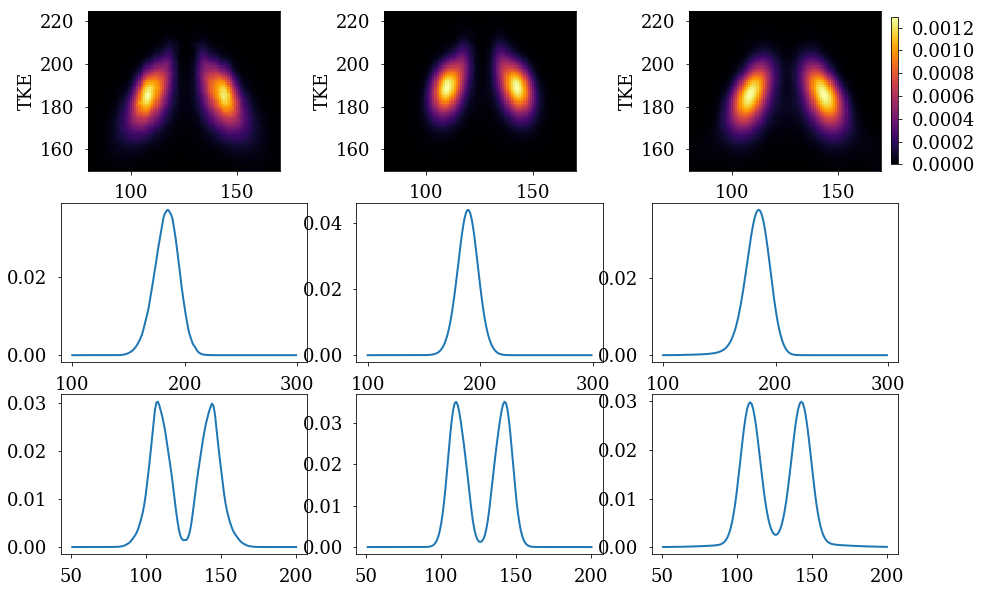

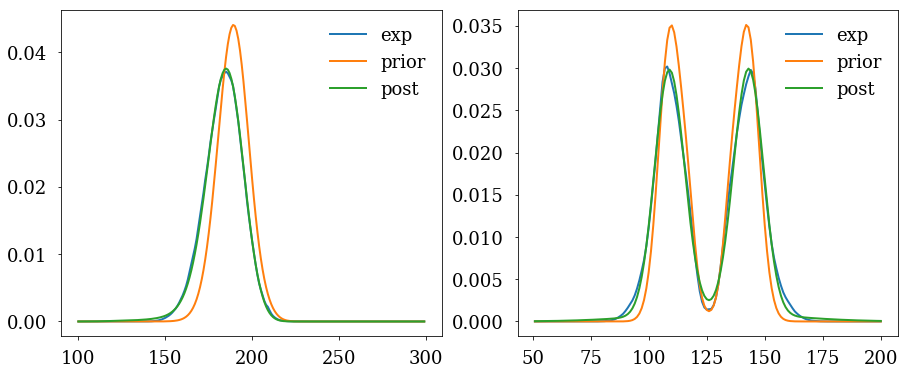

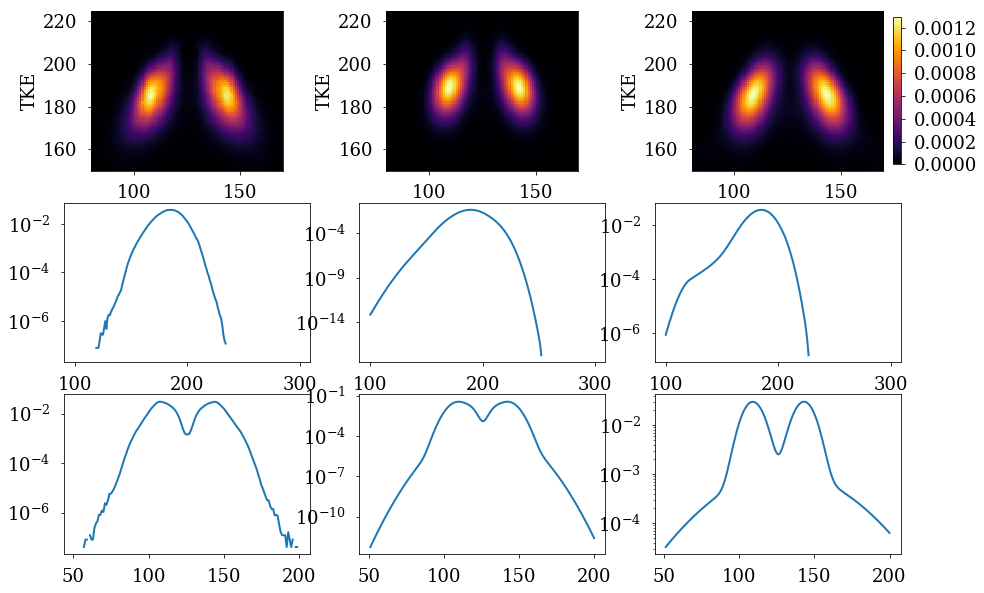

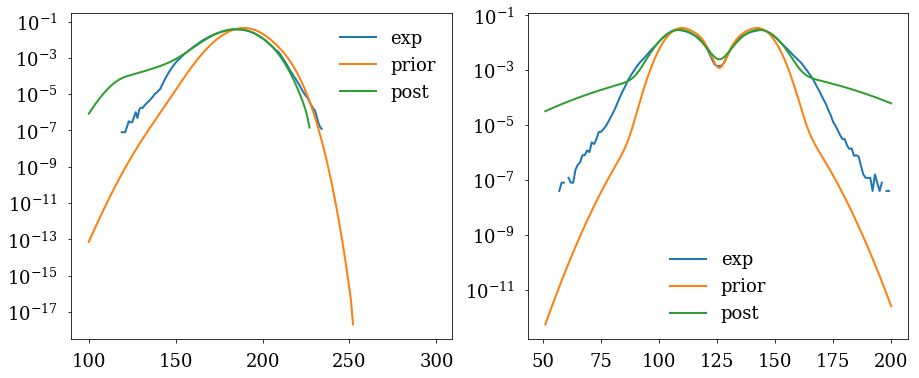

In [13]:

YATKE_post = YATKE((A,TKE), *popt)
lin_proj(rearrange(YATKE_data), rearrange(YATKE_prior), rearrange(YATKE_post))
log_proj(rearrange(YATKE_data), rearrange(YATKE_prior), rearrange(YATKE_post))

In [14]:
table = print_params(popt, guess0)

table

Parameter,Posterior Value,Prior Value,Delta,Delta (%)
$h_{l}$,74365.04,20200.00,54165.04,268.14%
$h_{s1}$,321154.85,147000.00,174154.85,118.47%
$h_{s2}$,557653.08,870000.00,-312346.92,-35.90%
"$d_{min,l}$",17.52,16.80,0.72,4.27%
"$d_{min,s1}$",10.00,10.90,-0.90,-8.27%
"$d_{min,s2}$",15.18,13.70,1.48,10.82%
"$d_{max,l}$",19.26,18.70,0.56,2.97%
"$d_{max,s1}$",17.62,17.10,0.52,3.02%
"$d_{max,s2}$",18.37,17.90,0.47,2.64%
"$d_{dec,l}$",0.57,0.52,0.05,9.63%


## What are the various Parameters

D - the distance between the centroids of the nascent fragments, more or less the same as the half-length of 
    the prescission shape
    
h - height; seeing that Y(TKE) function has a maximum at d_max - d_min
    
the Y(TKE) thus describes the fluctuations of the half-length (essentially D)

d_max - most probable length of prescission shape that results in rupture
        rupture at very long lengths is possible but the probability of this occuring decreases exponentially
        with
d_dec - length constant; determines the exponential decay of the prescission shape length that results in
        scission
        
d_min - shortest possible prescission shape, beyond which the probability of scission is 0




In [15]:
def getYTKE(YATKE):
    TKE = np.linspace(100,299,200)
    YTKE = np.zeros(len(TKE))
    # ROWS = TKE, COLUMNS = A
    for i in range(len(TKE)):
        YTKE[i]    = sum(YATKE[i,:])
    return YTKE
        
def getYA(YATKE):
    A = np.linspace(51,200,150)
    YA = np.zeros(len(A))
    # ROWS = TKE, COLUMNS = A
    for i in range(len(A)):
        YA[i]    = sum(YATKE[:,i])
    return YA

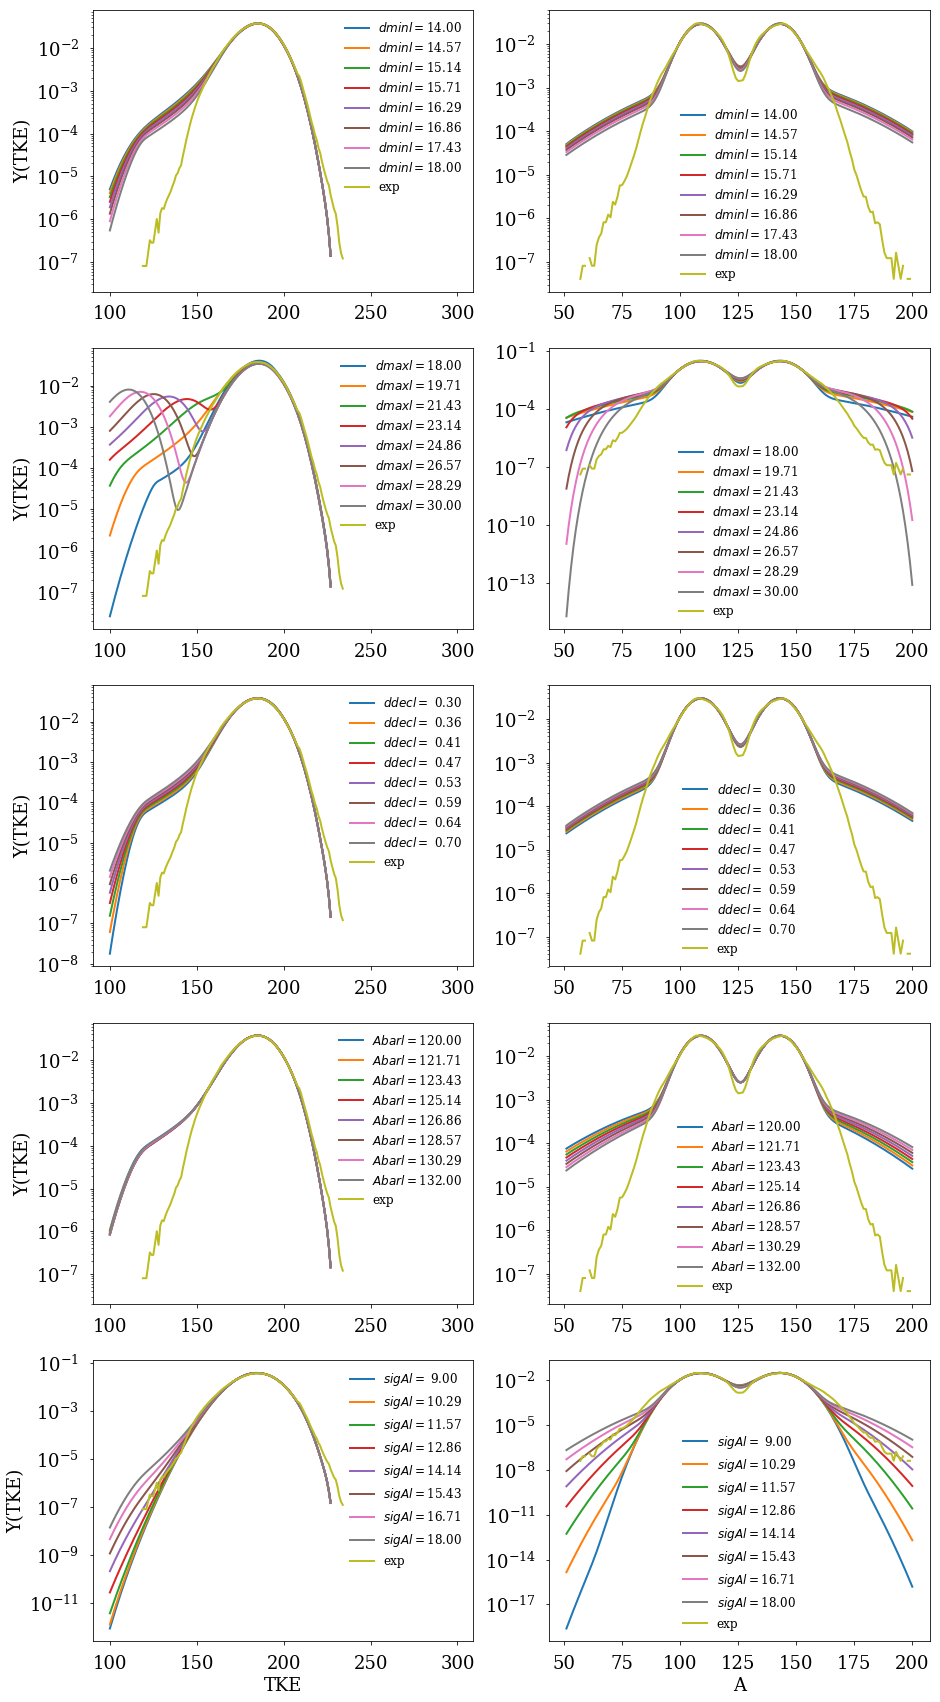

In [16]:
# show how adjustments in dmin, dmax, ddec affect Y(TKE) and Y(A)

# FOR EACH MODE
# 6 subplots
# 3x2 
# use popt for the other parameters

dminl = np.linspace(14.,18.,8)
dmaxl = np.linspace(18.,30.,8)
ddecl = np.linspace(0.3, 0.7, 8)
Abarl = np.linspace(120., 132., 8)
sigAl = np.linspace(9.,18.,8)

fig = plt.figure(figsize=(15, 30))

for i in range(8):
    dminlparams = np.concatenate([popt[0:3], np.array([dminl[i]]), popt[4:]])
    YATKE_dminl = YATKE((A,TKE), *dminlparams)
    plt.subplot(5,2,1)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dminl)), label = r'$dminl=${0:5.2f}'.format(dminl[i]))

    plt.subplot(5,2,2)
    plt.semilogy(A, getYA(rearrange(YATKE_dminl)), label = r'$dminl=${0:5.2f}'.format(dminl[i]))
    
    dmaxlparams = np.concatenate([popt[0:6], np.array([dmaxl[i]]), popt[7:]])
    YATKE_dmaxl = YATKE((A,TKE), *dmaxlparams)
    plt.subplot(5,2,3)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dmaxl)), label = r'$dmaxl=${0:5.2f}'.format(dmaxl[i]))

    plt.subplot(5,2,4)
    plt.semilogy(A, getYA(rearrange(YATKE_dmaxl)), label = r'$dmaxl=${0:5.2f}'.format(dmaxl[i]))

    ddeclparams = np.concatenate([popt[0:9], np.array([ddecl[i]]), popt[10:]])
    YATKE_ddecl = YATKE((A,TKE), *ddeclparams)
    plt.subplot(5,2,5)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_ddecl)), label = r'$ddecl=${0:5.2f}'.format(ddecl[i]))

    plt.subplot(5,2,6)
    plt.semilogy(A, getYA(rearrange(YATKE_ddecl)), label = r'$ddecl=${0:5.2f}'.format(ddecl[i])) 
    
    Abarlparams = np.concatenate([popt[0:12], np.array([Abarl[i]]), popt[13:]])
    YATKE_Abarl = YATKE((A,TKE), *Abarlparams)
    plt.subplot(5,2,7)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_Abarl)), label = r'$Abarl=${0:5.2f}'.format(Abarl[i]))

    plt.subplot(5,2,8)
    plt.semilogy(A, getYA(rearrange(YATKE_Abarl)), label = r'$Abarl=${0:5.2f}'.format(Abarl[i])) 
    
    sigAlparams = np.concatenate([popt[0:15], np.array([sigAl[i]]), popt[16:]])
    YATKE_sigAl = YATKE((A,TKE), *sigAlparams)
    plt.subplot(5,2,9)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_sigAl)), label = r'$sigAl=${0:5.2f}'.format(sigAl[i]))
    plt.xlabel('TKE')

    plt.subplot(5,2,10)
    plt.semilogy(A, getYA(rearrange(YATKE_sigAl)), label = r'$sigAl=${0:5.2f}'.format(sigAl[i])) 
    plt.xlabel('A')

for i in range(5):

    plt.subplot(5,2,(2*i +1))
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    plt.ylabel('Y(TKE)')

    plt.subplot(5,2,(2*i+2))
    plt.semilogy(A, getYA(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    

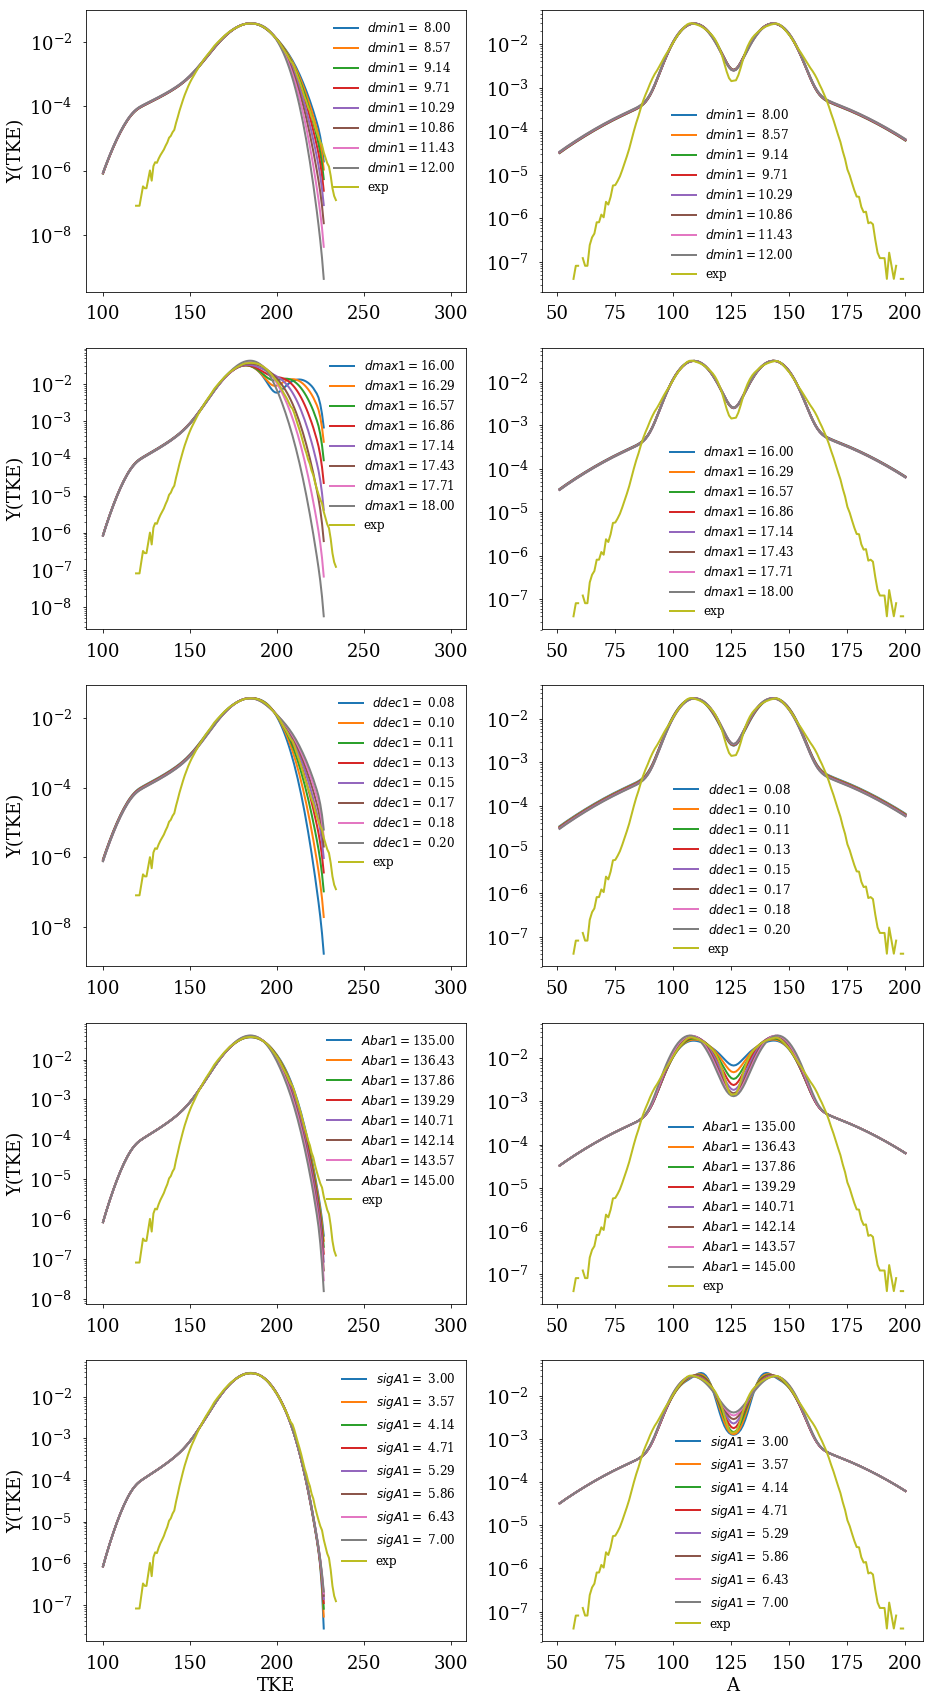

In [17]:
# show how adjustments in dmin, dmax, ddec affect Y(TKE) and Y(A)

# FOR EACH MODE
# 6 subplots
# 3x2 
# use popt for the other parameters

dmin1 = np.linspace(8., 12.,8)
dmax1 = np.linspace(16., 18. ,8)
ddec1 = np.linspace(0.08,0.2, 8)
Abar1 = np.linspace(135., 145., 8)
sigA1 = np.linspace(3.,7.,8)

fig = plt.figure(figsize=(15, 30))

for i in range(8):
    dmin1params = np.concatenate([popt[0:4], np.array([dmin1[i]]), popt[5:]])
    YATKE_dmin1 = YATKE((A,TKE), *dmin1params)
    plt.subplot(5,2,1)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dmin1)), label = r'$dmin1=${0:5.2f}'.format(dmin1[i]))

    plt.subplot(5,2,2)
    plt.semilogy(A, getYA(rearrange(YATKE_dmin1)), label = r'$dmin1=${0:5.2f}'.format(dmin1[i]))
    
    dmax1params = np.concatenate([popt[0:7], np.array([dmax1[i]]), popt[8:]])
    YATKE_dmax1 = YATKE((A,TKE), *dmax1params)
    plt.subplot(5,2,3)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dmax1)), label = r'$dmax1=${0:5.2f}'.format(dmax1[i]))

    plt.subplot(5,2,4)
    plt.semilogy(A, getYA(rearrange(YATKE_dmax1)), label = r'$dmax1=${0:5.2f}'.format(dmax1[i]))

    ddec1params = np.concatenate([popt[0:10], np.array([ddec1[i]]), popt[11:]])
    YATKE_ddec1 = YATKE((A,TKE), *ddec1params)
    plt.subplot(5,2,5)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_ddec1)), label = r'$ddec1=${0:5.2f}'.format(ddec1[i]))

    plt.subplot(5,2,6)
    plt.semilogy(A, getYA(rearrange(YATKE_ddec1)), label = r'$ddec1=${0:5.2f}'.format(ddec1[i])) 
    
    Abar1params = np.concatenate([popt[0:13], np.array([Abar1[i]]), popt[14:]])
    YATKE_Abar1 = YATKE((A,TKE), *Abar1params)
    plt.subplot(5,2,7)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_Abar1)), label = r'$Abar1=${0:5.2f}'.format(Abar1[i]))

    plt.subplot(5,2,8)
    plt.semilogy(A, getYA(rearrange(YATKE_Abar1)), label = r'$Abar1=${0:5.2f}'.format(Abar1[i])) 
    
    sigA1params = np.concatenate([popt[0:16], np.array([sigA1[i]]), popt[17:]])
    YATKE_sigA1 = YATKE((A,TKE), *sigA1params)
    plt.subplot(5,2,9)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_sigA1)), label = r'$sigA1=${0:5.2f}'.format(sigA1[i]))
    plt.xlabel('TKE')

    plt.subplot(5,2,10)
    plt.semilogy(A, getYA(rearrange(YATKE_sigA1)), label = r'$sigA1=${0:5.2f}'.format(sigA1[i])) 
    plt.xlabel('A')

for i in range(5):

    plt.subplot(5,2,(2*i +1))
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    plt.ylabel('Y(TKE)')

    plt.subplot(5,2,(2*i+2))
    plt.semilogy(A, getYA(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    

(1e-07, 0.1)

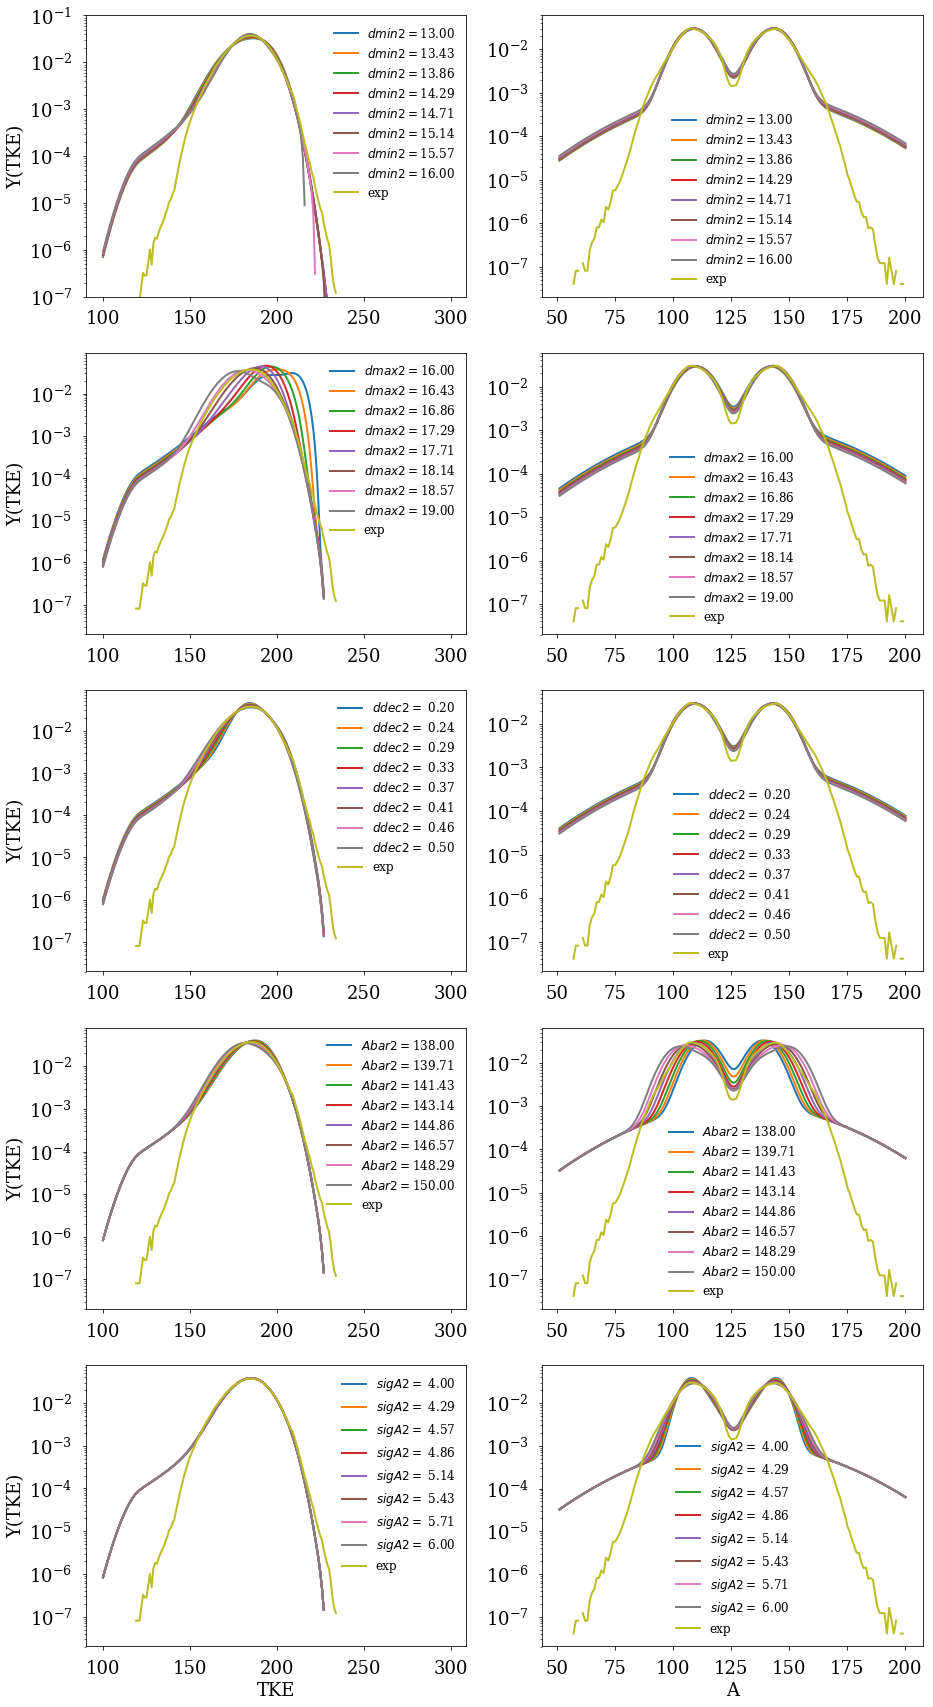

In [18]:
# S2 ******************************************************************************************

# show how adjustments in dmin, dmax, ddec affect Y(TKE) and Y(A)

# FOR EACH MODE
# 6 subplots
# 3x2 
# use popt for the other parameters

dmin2 = np.linspace(13., 16.,8)
dmax2 = np.linspace(16., 19. ,8)
ddec2 = np.linspace(0.2,0.5, 8)
Abar2 = np.linspace(138., 150., 8)
sigA2 = np.linspace(4.,6.,8)

fig = plt.figure(figsize=(15, 30))

for i in range(8):
    dmin2params = np.concatenate([popt[0:5], np.array([dmin2[i]]), popt[6:]])
    YATKE_dmin2 = YATKE((A,TKE), *dmin2params)
    plt.subplot(5,2,1)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dmin2)), label = r'$dmin2=${0:5.2f}'.format(dmin2[i]))

    plt.subplot(5,2,2)
    plt.semilogy(A, getYA(rearrange(YATKE_dmin2)), label = r'$dmin2=${0:5.2f}'.format(dmin2[i]))
    
    dmax2params = np.concatenate([popt[0:8], np.array([dmax2[i]]), popt[9:]])
    YATKE_dmax2 = YATKE((A,TKE), *dmax2params)
    plt.subplot(5,2,3)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_dmax2)), label = r'$dmax2=${0:5.2f}'.format(dmax2[i]))

    plt.subplot(5,2,4)
    plt.semilogy(A, getYA(rearrange(YATKE_dmax2)), label = r'$dmax2=${0:5.2f}'.format(dmax2[i]))

    ddec2params = np.concatenate([popt[0:11], np.array([ddec2[i]]), popt[12:]])
    YATKE_ddec2 = YATKE((A,TKE), *ddec2params)
    plt.subplot(5,2,5)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_ddec2)), label = r'$ddec2=${0:5.2f}'.format(ddec2[i]))

    plt.subplot(5,2,6)
    plt.semilogy(A, getYA(rearrange(YATKE_ddec2)), label = r'$ddec2=${0:5.2f}'.format(ddec2[i])) 
    
    Abar2params = np.concatenate([popt[0:14], np.array([Abar2[i]]), popt[15:]])
    YATKE_Abar2 = YATKE((A,TKE), *Abar2params)
    plt.subplot(5,2,7)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_Abar2)), label = r'$Abar2=${0:5.2f}'.format(Abar2[i]))

    plt.subplot(5,2,8)
    plt.semilogy(A, getYA(rearrange(YATKE_Abar2)), label = r'$Abar2=${0:5.2f}'.format(Abar2[i])) 
    
    sigA2params = np.concatenate([popt[0:17], np.array([sigA2[i]]), popt[18:]])
    YATKE_sigA2 = YATKE((A,TKE), *sigA2params)
    plt.subplot(5,2,9)
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_sigA2)), label = r'$sigA2=${0:5.2f}'.format(sigA2[i]))
    plt.xlabel('TKE')

    plt.subplot(5,2,10)
    plt.semilogy(A, getYA(rearrange(YATKE_sigA2)), label = r'$sigA2=${0:5.2f}'.format(sigA2[i])) 
    plt.xlabel('A')

for i in range(5):

    plt.subplot(5,2,(2*i +1))
    plt.semilogy(TKE, getYTKE(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    plt.ylabel('Y(TKE)')

    plt.subplot(5,2,(2*i+2))
    plt.semilogy(A, getYA(rearrange(YATKE_data)), label = 'exp')
    lg = plt.legend(numpoints=1,fontsize=12, loc='best')
    lg.draw_frame(False)
    
plt.subplot(5,2,1)
plt.ylim(1e-7, 1e-1)


In [19]:
YATKE_popt = YATKE((A,TKE), *popt)

sigAlparams = np.concatenate([popt[0:15], np.array([14.14]), popt[16:]])
YATKE_sigAl = YATKE((A,TKE), *sigAlparams)
chi2l = chisquare(YATKE_sigAl[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2l)

chi2popt = chisquare(YATKE_popt[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2popt)

Power_divergenceResult(statistic=0.062966449209837239, pvalue=1.0)
Power_divergenceResult(statistic=0.47818691692309451, pvalue=1.0)


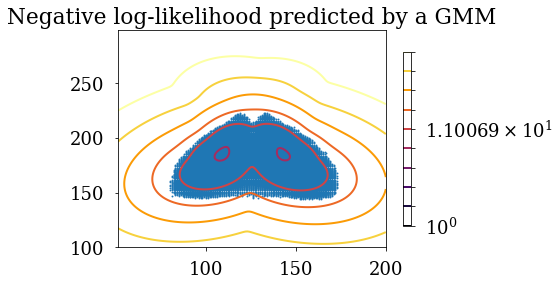

In [75]:
# NEW Optimization scheme 
# testing the density estimation for a mixture of gaussians

from matplotlib.colors import LogNorm
from sklearn import mixture

# generate the training set
#get yield data for Cf 252 *************************************************************************************
f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
lines=f.readlines()
YATKE_datammg=[]
for x in lines:
    x = x.split()
    if len(x) != 0:
        YATKE_datammg.append(x[2])
f.close()

#convert from strings to ints
YATKE_datammg = list(map(int, YATKE_datammg))

YATKE_datammg2d = rearrange(YATKE_datammg)

X_train = []
for i in range(len(A)):
    for j in range(len(TKE)):
        for k in range(int(YATKE_datammg2d[j,i]/32.)):
            X_train.append([A[i], TKE[j]])
X_train = np.array(X_train)
clf = mixture.GaussianMixture(n_components=6, covariance_type='full')
clf.fit(X_train)



# display predicted scores by the model as a contour plot

Amesh, TKEmesh = np.meshgrid(A, TKE)
AA = np.array([Amesh.ravel(), TKEmesh.ravel()]).T
Z = -clf.score_samples(AA)
Z = Z.reshape(Amesh.shape)

CS = plt.contour(Amesh, TKEmesh, Z, norm=LogNorm(vmin=1.0, vmax=75.0),
                 levels=np.logspace(0, 1.875, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()



In [ ]:
print (clf.means_)
print(clf.weights_)

In [54]:
print(max((YATKE_datammg2d/4001.).all()))

TypeError: 'numpy.bool_' object is not iterable

In [22]:
Amesh, TKEmesh = np.meshgrid(A, TKE)
print(TKEmesh)

[[ 100.  100.  100. ...,  100.  100.  100.]
 [ 101.  101.  101. ...,  101.  101.  101.]
 [ 102.  102.  102. ...,  102.  102.  102.]
 ..., 
 [ 297.  297.  297. ...,  297.  297.  297.]
 [ 298.  298.  298. ...,  298.  298.  298.]
 [ 299.  299.  299. ...,  299.  299.  299.]]
